# **Validation for Binomial Confidence Interval**

The goal of this notebook is to empirically validate the correctness of the binomial confidence interval. Specifically, we test the coverage and expected excess length guarantees for the lower bound, upper bound, and 2-sided bound. In addition, we test the unbiased property of the 2-sided bound.

Setup: given n, alpha, and the true value of p, sample n observations from Bernoulli(p) and compute a confidence interval. From the interval compute the coverage and excess length. Repeat this process and plot convergence of average coverage and average excess length.


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '..')
from binomial_cis import binom_ci, llc_accept_prob, expected_shortage, expected_excess, expected_shortage_cp
from binomial_cis import accept_prob, accept_prob_cp, accept_prob_2_sided
from binomial_cis import expected_width, llc_accept_prob_2_sided, max_accept_prob_2_sided

In [43]:
def running_average(items):
    """
    Inputs
    items: list of values

    Returns
    average: list of the empirical average value at each step
    """
    # use cumulative average formula: https://en.wikipedia.org/wiki/Moving_average#Cumulative_average
    average = np.zeros(len(items))
    count = 0
    for i,s in enumerate(items):
        average[i] = (s + count*average[i-1]) / (count + 1)
        count += 1
    
    return average

### Compute MC Samples

In [44]:
# set up scenario
alpha = 0.05
n = 10
p = 0.75
num = 500

# compute theoretical confidence levels
args = [p, alpha, n, p]
lb_conf = accept_prob(4, args)
cp_lb_conf = accept_prob_cp(4, args)
lb_ub_conf = accept_prob_2_sided(5, [p, alpha, n, p, p])

# compute theoretical expected shortage (lb), excess (ub), and width (2-sided)
exp_shortage = expected_shortage(llc_accept_prob, alpha, n, p)
exp_shortage_cp = expected_shortage_cp(alpha, n, p)
exp_excess = expected_excess(llc_accept_prob, alpha, n, p)
exp_width = expected_width(llc_accept_prob_2_sided, alpha, n, p)

# make data structures
coverage_lb = np.zeros(num)
shortage = np.zeros(num)

coverage_lb_cp = np.zeros(num)
shortage_cp = np.zeros(num)

coverage_ub = np.zeros(num)
excess = np.zeros(num)

coverage_2side = np.zeros(num)
width = np.zeros(num)


# run multiple experiments
for i in range(num):
    print("\ni: ", i) if i%100 == 0 else None
    
    # sample n observations from Bernoulli(p)
    num_successes = np.random.binomial(n, p)

    # compute confidence intervals
    lb = binom_ci(num_successes, n, alpha, "lb", verbose=False)
    ub = binom_ci(num_successes, n, alpha, "ub", verbose=False)
    lb2, ub2 = binom_ci(num_successes, n, alpha, "lb,ub", verbose=False)
    lb_cp = binom_ci(num_successes, n, alpha, "lb", verbose=False, randomized=False)

    # compute empirical coverage and excess volume
    coverage_lb[i] = lb <= p
    shortage[i] = max(0, p - lb) # p - lb if p >= lb else 0

    coverage_lb_cp[i] = lb_cp <= p
    shortage_cp[i] = max(0, p - lb_cp) # p - lb if p >= lb else 0

    coverage_ub[i] = ub >= p
    excess[i] = max(0, ub - p) # ub - p if ub >= p else 0

    coverage_2side[i] = p >= lb2 and p <= ub2
    width[i] = ub2 - lb2

      

# obtain average coverage and excess volume
avg_coverage_lb = running_average(coverage_lb)
avg_shortage = running_average(shortage)

avg_coverage_lb_cp = running_average(coverage_lb_cp)
avg_shortage_cp = running_average(shortage_cp)

avg_coverage_ub = running_average(coverage_ub)
avg_excess = running_average(excess)

avg_coverage_2side = running_average(coverage_2side)
avg_width = running_average(width)

/home/joevincent/Documents/binomial_CIs/tests/../binomial_cis/volume.py:24: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  exp_shortage, tolerance = integrate.quad(accept_prob, eps, p, args=(alpha, n, p))
/home/joevincent/Documents/binomial_CIs/tests/../binomial_cis/volume.py:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 


i:  0

i:  100

i:  200

i:  300

i:  400


### Plot & Print Results

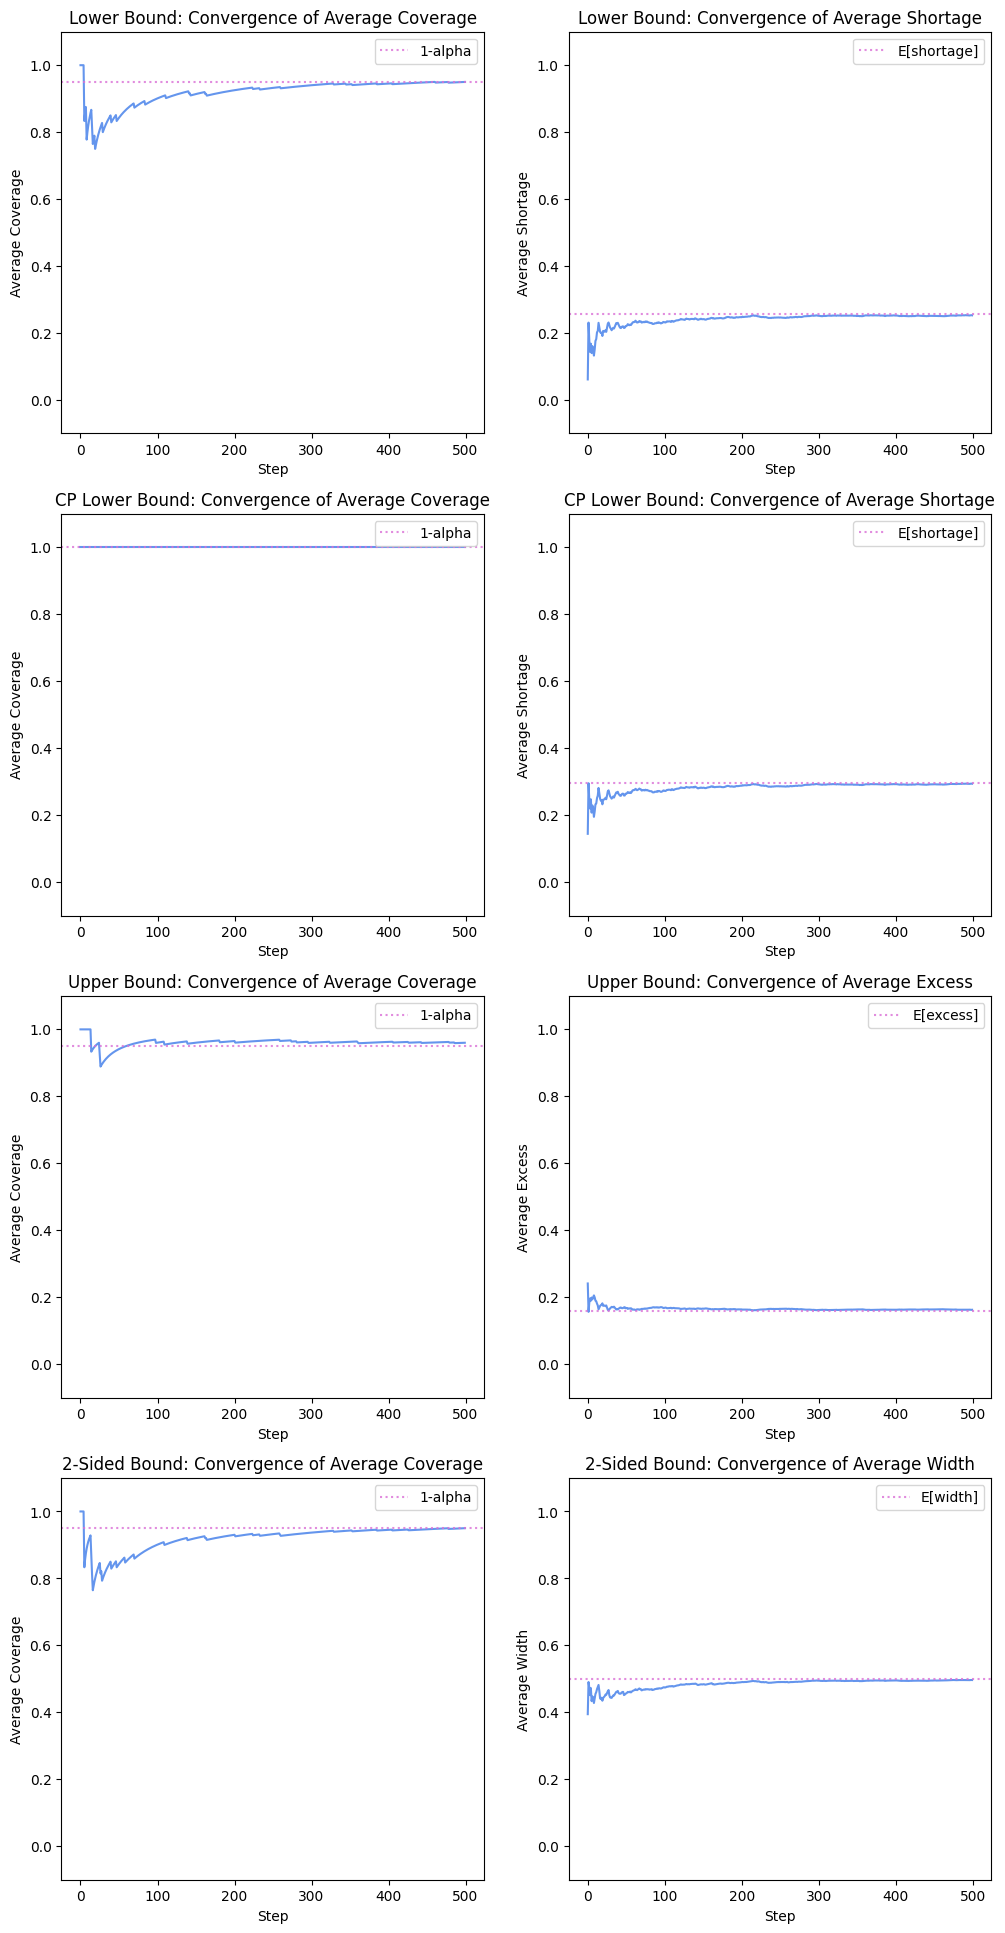

In [45]:
# plot results
plt.figure(figsize=(12,24))
plt.subplot(4,2,1)
plt.plot(range(num), avg_coverage_lb, color="cornflowerblue")
plt.axhline(y = lb_conf, color = 'orchid', linestyle = 'dotted', label="1-alpha", alpha=0.8)
plt.ylim(-0.1,1.1)
plt.xlabel("Step")
plt.ylabel("Average Coverage")
plt.title("Lower Bound: Convergence of Average Coverage")
plt.legend()

plt.subplot(4,2,2)
plt.plot(range(num), avg_shortage, color="cornflowerblue")
plt.axhline(y = exp_shortage, color = 'orchid', linestyle = 'dotted', label="E[shortage]", alpha=0.8)
plt.ylim(-0.1,1.1)
plt.xlabel("Step")
plt.ylabel("Average Shortage")
plt.title("Lower Bound: Convergence of Average Shortage")
plt.legend()

# Clopper-Pearson
plt.subplot(4,2,3)
plt.plot(range(num), avg_coverage_lb_cp, color="cornflowerblue")
plt.axhline(y = cp_lb_conf, color = 'orchid', linestyle = 'dotted', label="1-alpha", alpha=0.8)
plt.ylim(-0.1,1.1)
plt.xlabel("Step")
plt.ylabel("Average Coverage")
plt.title("CP Lower Bound: Convergence of Average Coverage")
plt.legend()

plt.subplot(4,2,4)
plt.plot(range(num), avg_shortage_cp, color="cornflowerblue")
plt.axhline(y = exp_shortage_cp, color = 'orchid', linestyle = 'dotted', label="E[shortage]", alpha=0.8)
plt.ylim(-0.1,1.1)
plt.xlabel("Step")
plt.ylabel("Average Shortage")
plt.title("CP Lower Bound: Convergence of Average Shortage")
plt.legend()

plt.subplot(4,2,5)
plt.plot(range(num), avg_coverage_ub, color="cornflowerblue")
plt.axhline(y = lb_conf, color = 'orchid', linestyle = 'dotted', label="1-alpha", alpha=0.8)
plt.ylim(-0.1,1.1)
plt.xlabel("Step")
plt.ylabel("Average Coverage")
plt.title("Upper Bound: Convergence of Average Coverage")
plt.legend()

plt.subplot(4,2,6)
plt.plot(range(num), avg_excess, color="cornflowerblue")
plt.axhline(y = exp_excess, color = 'orchid', linestyle = 'dotted', label="E[excess]", alpha=0.8)
plt.ylim(-0.1,1.1)
plt.xlabel("Step")
plt.ylabel("Average Excess")
plt.title("Upper Bound: Convergence of Average Excess")
plt.legend()

plt.subplot(4,2,7)
plt.plot(range(num), avg_coverage_2side, color="cornflowerblue")
plt.axhline(y = lb_ub_conf, color = 'orchid', linestyle = 'dotted', label="1-alpha", alpha=0.8)
plt.ylim(-0.1,1.1)
plt.xlabel("Step")
plt.ylabel("Average Coverage")
plt.title("2-Sided Bound: Convergence of Average Coverage")
plt.legend()

plt.subplot(4,2,8)
plt.plot(range(num), avg_width, color="cornflowerblue")
plt.axhline(y = exp_width, color = 'orchid', linestyle = 'dotted', label="E[width]", alpha=0.8)
plt.ylim(-0.1,1.1)
plt.xlabel("Step")
plt.ylabel("Average Width")
plt.title("2-Sided Bound: Convergence of Average Width")
plt.legend()

In [48]:

# Note, we may not get exact coverage due to the cases where the bisection search has no solution and we end up with slight overcoverage
print("Desired Coverage: ", 1-alpha)

print("\nLower Bound: E[coverage]: ", lb_conf)
print("Lower Bound: MC coverage: ", avg_coverage_lb[-1])
print("Lower Bound: E[shortage]: ", exp_shortage)
print("Lower Bound: MC shortage: ", avg_shortage[-1])

print("\nCP Lower Bound: E[coverage]: ", cp_lb_conf)
print("CP Lower Bound: MC coverage: ", avg_coverage_lb_cp[-1])
print("CP Lower Bound: E[shortage]: ", exp_shortage_cp)
print("CP Lower Bound: MC shortage: ", avg_shortage_cp[-1])

print("\nUpper Bound: E[coverage]: ", lb_conf)
print("Upper Bound: MC coverage: ", avg_coverage_ub[-1])
print("Upper Bound: E[excess]: ", exp_excess)
print("Upper Bound: MC excess: ", avg_excess[-1])

print("\n2-Sided Bound: E[coverage]: ", lb_ub_conf)
print("2-Sided Bound: MC coverage: ", avg_coverage_2side[-1])
print("2-Sided Bound: E[width]: ", exp_width)
print("2-Sided Bound: MC width: ", avg_width[-1])

Desired Coverage:  0.95

Lower Bound: E[coverage]:  0.9500004993542464
Lower Bound: MC coverage:  0.95
Lower Bound: E[shortage]:  0.25625820405930505
Lower Bound: MC shortage:  0.2528579070537368

CP Lower Bound: E[coverage]:  1
CP Lower Bound: MC coverage:  1.0
CP Lower Bound: E[shortage]:  0.2972143715302241
CP Lower Bound: MC shortage:  0.2938120574863554

Upper Bound: E[coverage]:  0.9500004993542464
Upper Bound: MC coverage:  0.96
Upper Bound: E[excess]:  0.15919629842484648
Upper Bound: MC excess:  0.16241023237719357

2-Sided Bound: E[coverage]:  0.95
2-Sided Bound: MC coverage:  0.95
2-Sided Bound: E[width]:  0.4983477597414813
2-Sided Bound: MC width:  0.4965006453410161


## Check Unbiased Property
The unbiased property of the 2-sided interval means that the true value of $p$ has the highest probability of being included  in the interval, and that probability of inclusion is exactly the coverage probability $1-\alpha$.

In [47]:
# grid search for highest probability of inclusion (max_ap) and where it occurs (max_p_0)
n_grid = 5_001
max_ap, max_p_0 = max_accept_prob_2_sided(alpha, n, p, n_grid)

print("\nChecking unbiased property:")
print("True p:", p)
print("p_0 with max inclusion prob: p_0 =", round(max_p_0,4), "with inclusion probability", round(max_ap,4))


Checking unbiased property:
True p: 0.75
p_0 with max inclusion prob: p_0 = 0.75 with inclusion probability 0.95
